# Preprocessing, manifold and clustering scRNA-seq villus

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import scanpy as sc
import pandas as pd
import seaborn as sns
from scipy.sparse import csr_matrix
from matplotlib import rcParams

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.0 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=300,transparent=True, frameon=False)

In [4]:
sc.settings.figdir='./figures'

## Load raw data

In [6]:
adata = sc.read('./data/adata_villus_raw.h5ad')

In [9]:
# decoding necessary for some scanpy versions
for obs_key in ['diet']:
    adata.obs[obs_key] = [str(obs.decode('UTF-8')) for obs in adata.obs[obs_key]]
adata.var_names = [str(obs.decode('UTF-8')) for obs in adata.var_names]
adata.obs_names = [str(obs.decode('UTF-8')) for obs in adata.obs_names]

## QC and preprocessing

In [10]:
# Quality control - calculate QC covariates for all anndata objects
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['n_genes'] = (adata.X > 0).sum(1)
mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
mt_gene_index = np.where(mt_gene_mask)[0]
adata.obs['mt_fraction'] = adata.X[:,mt_gene_index].sum(1) / adata.X.sum(1)

... storing 'diet' as categorical
/Users/stritschler/code/miniconda3/envs/scanpy_14/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/stritschler/code/miniconda3/envs/scanpy_14/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/stritschler/code/miniconda3/envs/scanpy_14/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing o

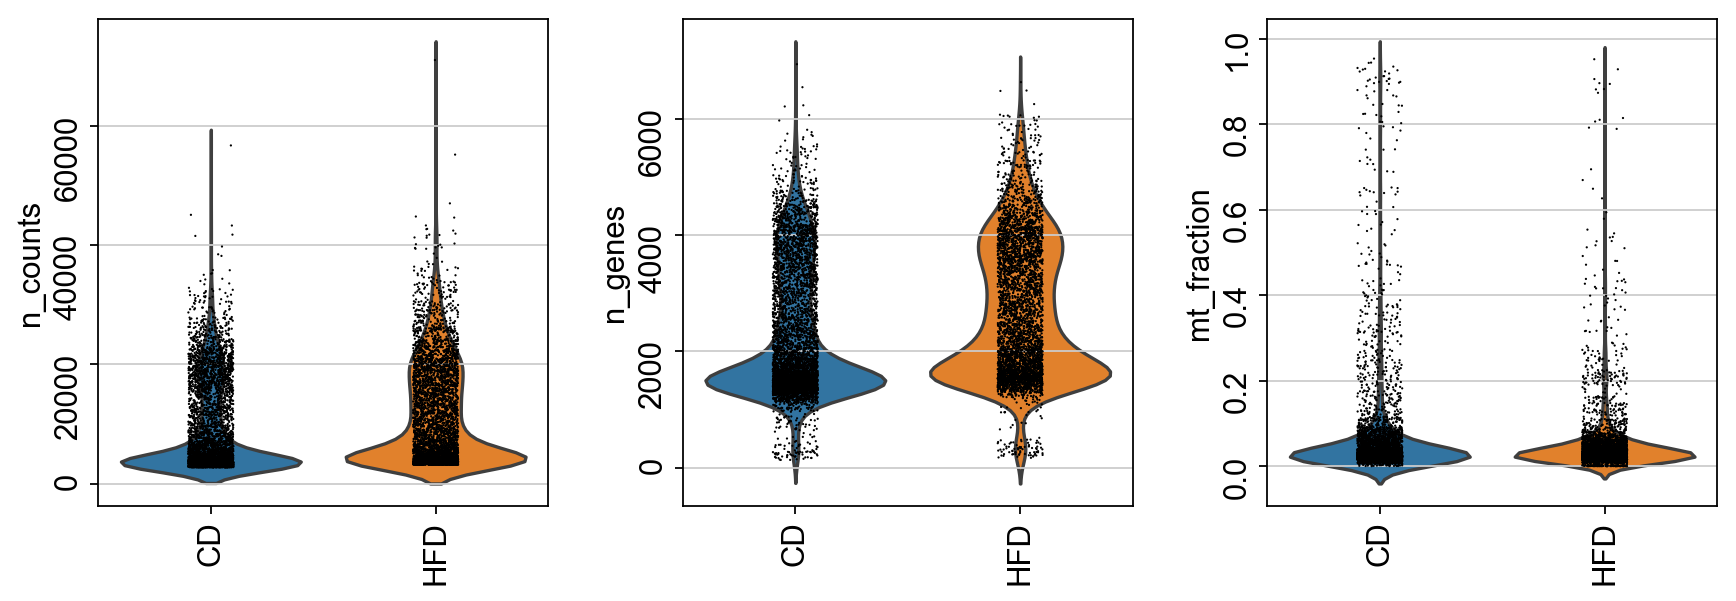

In [11]:
sc.pl.violin(adata, ['n_counts','n_genes', 'mt_fraction'], groupby='diet', size=1, log=False,rotation=90)

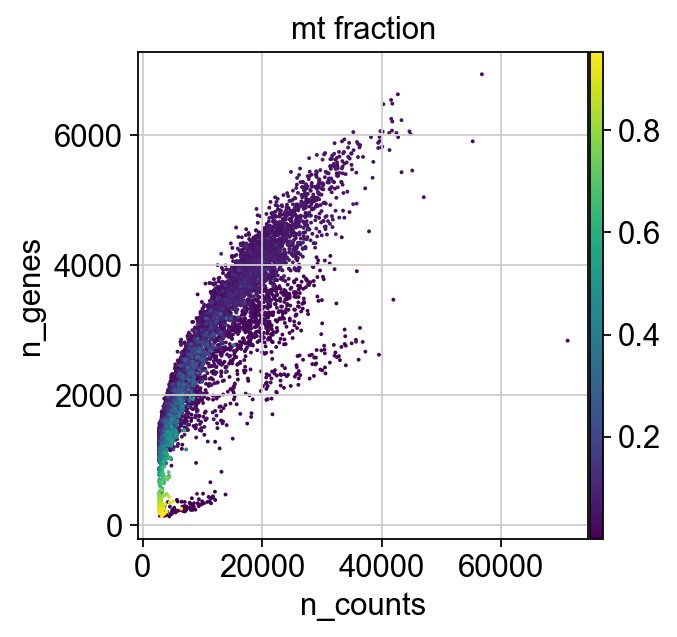

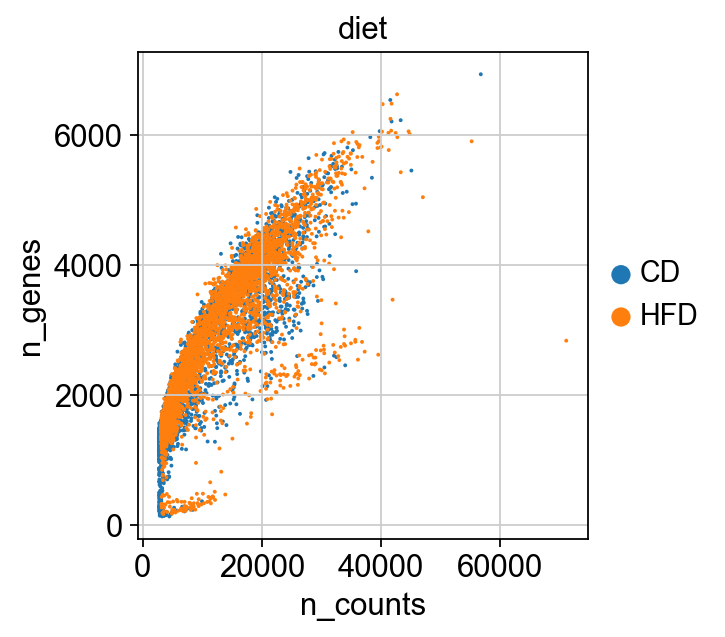

In [13]:
sc.pl.scatter(adata, y='n_genes', x='n_counts', color='mt_fraction')
sc.pl.scatter(adata, y='n_genes', x='n_counts', color='diet')

### save raw count matrix

In [13]:
adata.write('./data/adata_villus_raw.h5ad')

### filtering and normalization

In [14]:
sc.pp.filter_genes(adata, min_cells=1)

filtered out 9758 genes that are detectedin less than 1 cells


In [15]:
#Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

Total number of cells: 9852


In [16]:
# normalization
sc.pp.normalize_total(adata, exclude_highly_expressed=True)
sc.pp.log1p(adata)

Normalizing counts per cell. The following highly-expressed genes are not considered during normalization factor computation:
['Xcl1', 'Gcg', 'Chgb', 'Tmsb4x', 'Reg4', 'Fabp2', 'Clca1', 'Spink4', 'Jchain', 'Afp', 'Igkc', 'Fabp1', 'Reg3b', 'Reg1', 'Reg3g', 'Ghrl', 'Apoe', 'Fcgbp', 'Hbb-bt', 'Hbb-bs', 'Zg16', 'Sct', 'Muc2', 'Nts', 'Lyz2', 'Defa30', 'AY761184', 'Defa24', 'Mcpt1', 'Mcpt2', 'Olfm4', 'Apoa1', 'Apoa4', 'Rbp2', 'Cck', 'Hba-a1', 'Hba-a2', 'Fabp6', 'Ccl5', 'Ccl4', 'Gip', 'Pyy', 'Gzma', 'Crip1', 'Igha', 'Ighg2b', 'Ighg1', 'Ighg3', 'Ighm', 'Iglc1', 'Sst', 'Tff3', 'Gm42418', 'Cd74', 'Malat1', 'Fth1', 'mt-Nd1', 'mt-Co1', 'mt-Co2', 'mt-Atp6', 'mt-Co3', 'mt-Nd4', 'mt-Cytb']
    finished (0:00:00):normalized adata.X


## Iterative manifold, clustering and cell filtering

In [17]:
sc.pp.highly_variable_genes(adata)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [18]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 50


/Users/stritschler/code/miniconda3/envs/scanpy_14/lib/python3.6/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../code/miniconda3/envs/scanpy_14/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/Users/stritschler/code/miniconda3/envs/scanpy_14/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagno

    finished (0:00:06)
computing UMAP
    finished (0:00:14)


### exclude immune cells and fibroblasts

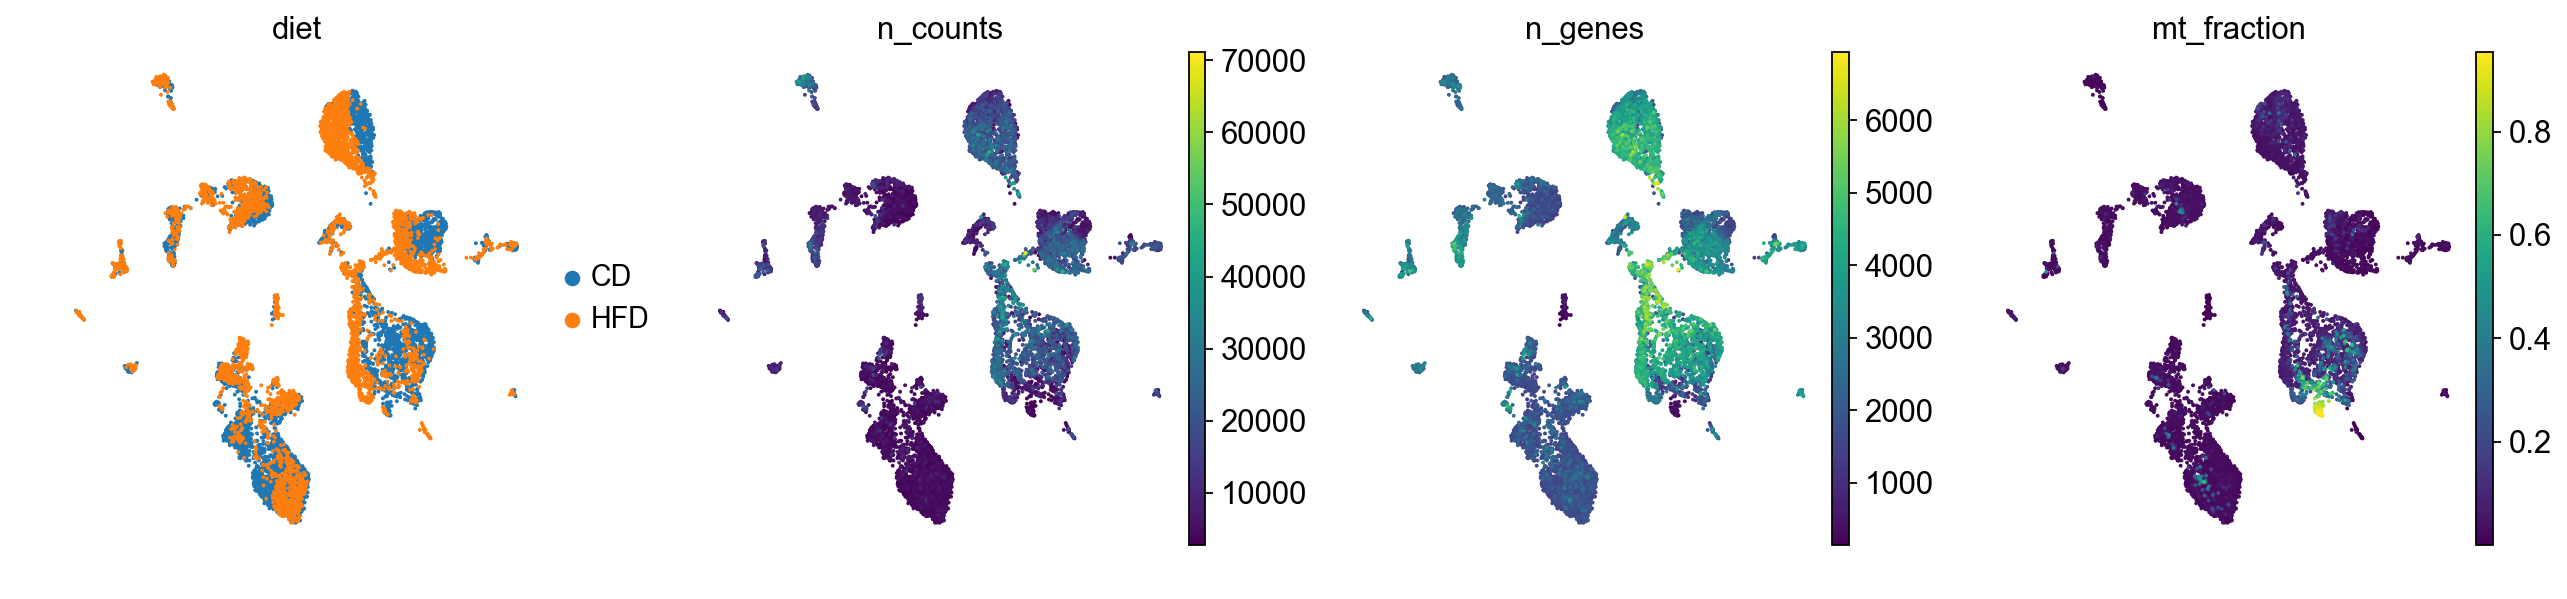

In [19]:
sc.pl.umap(adata, color=['diet','n_counts','n_genes', 'mt_fraction'])

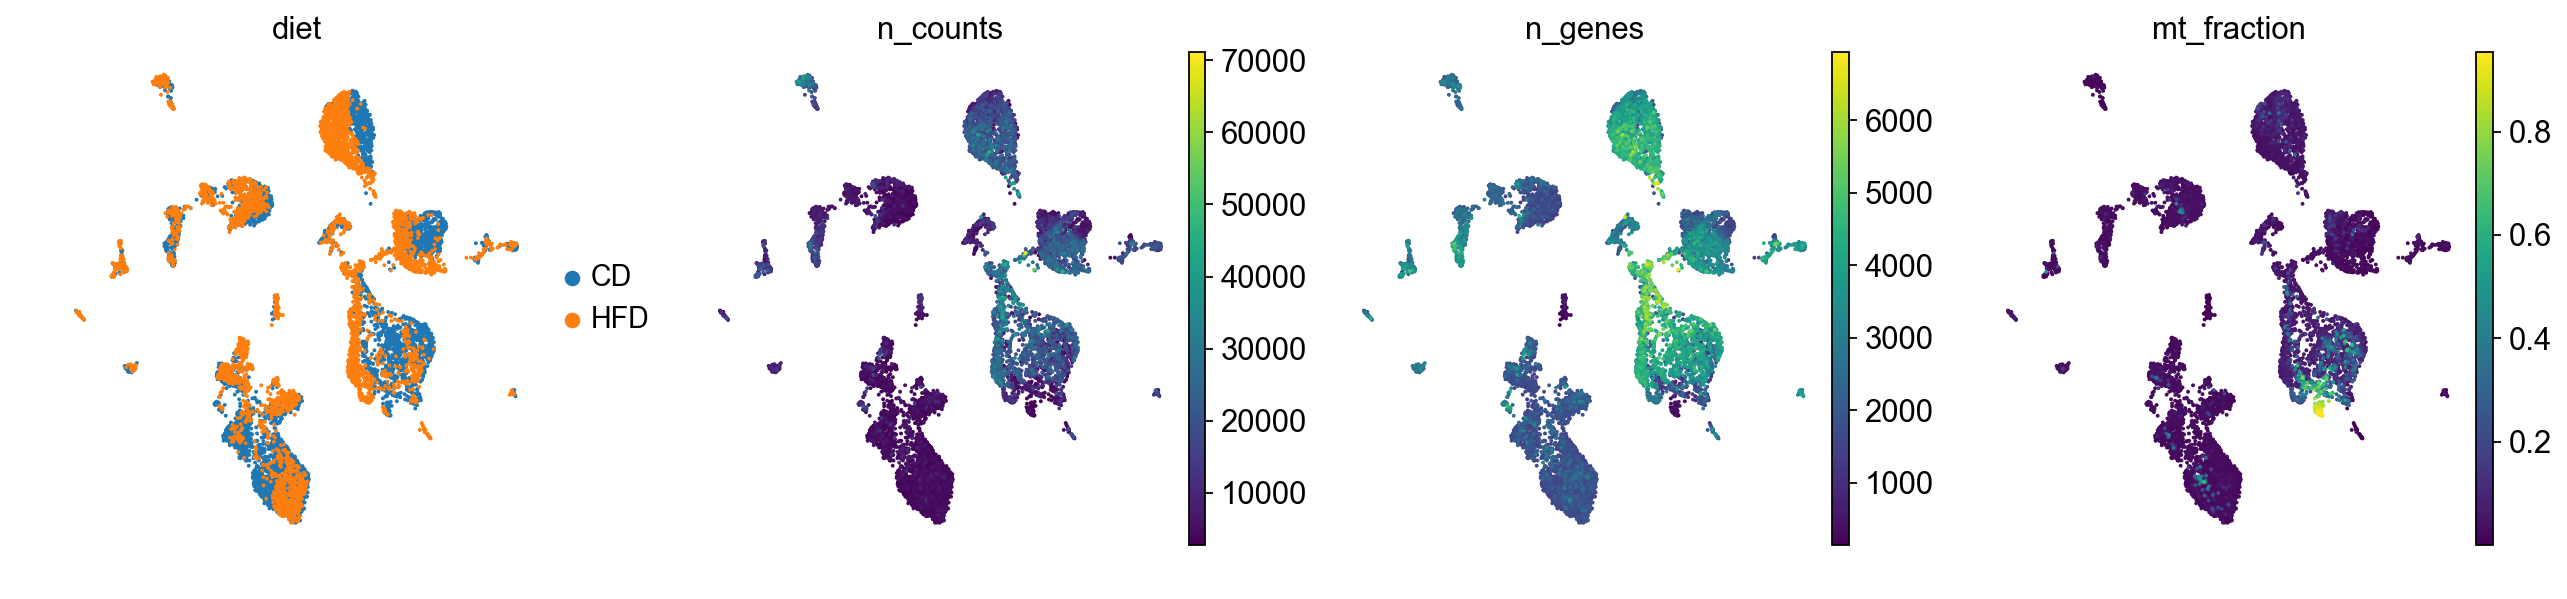

In [20]:
sc.pl.umap(adata, color=['diet','n_counts','n_genes', 'mt_fraction'])

In [21]:
sc.tl.louvain(adata, resolution=0.3)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


immune cell and fibroblast markers:

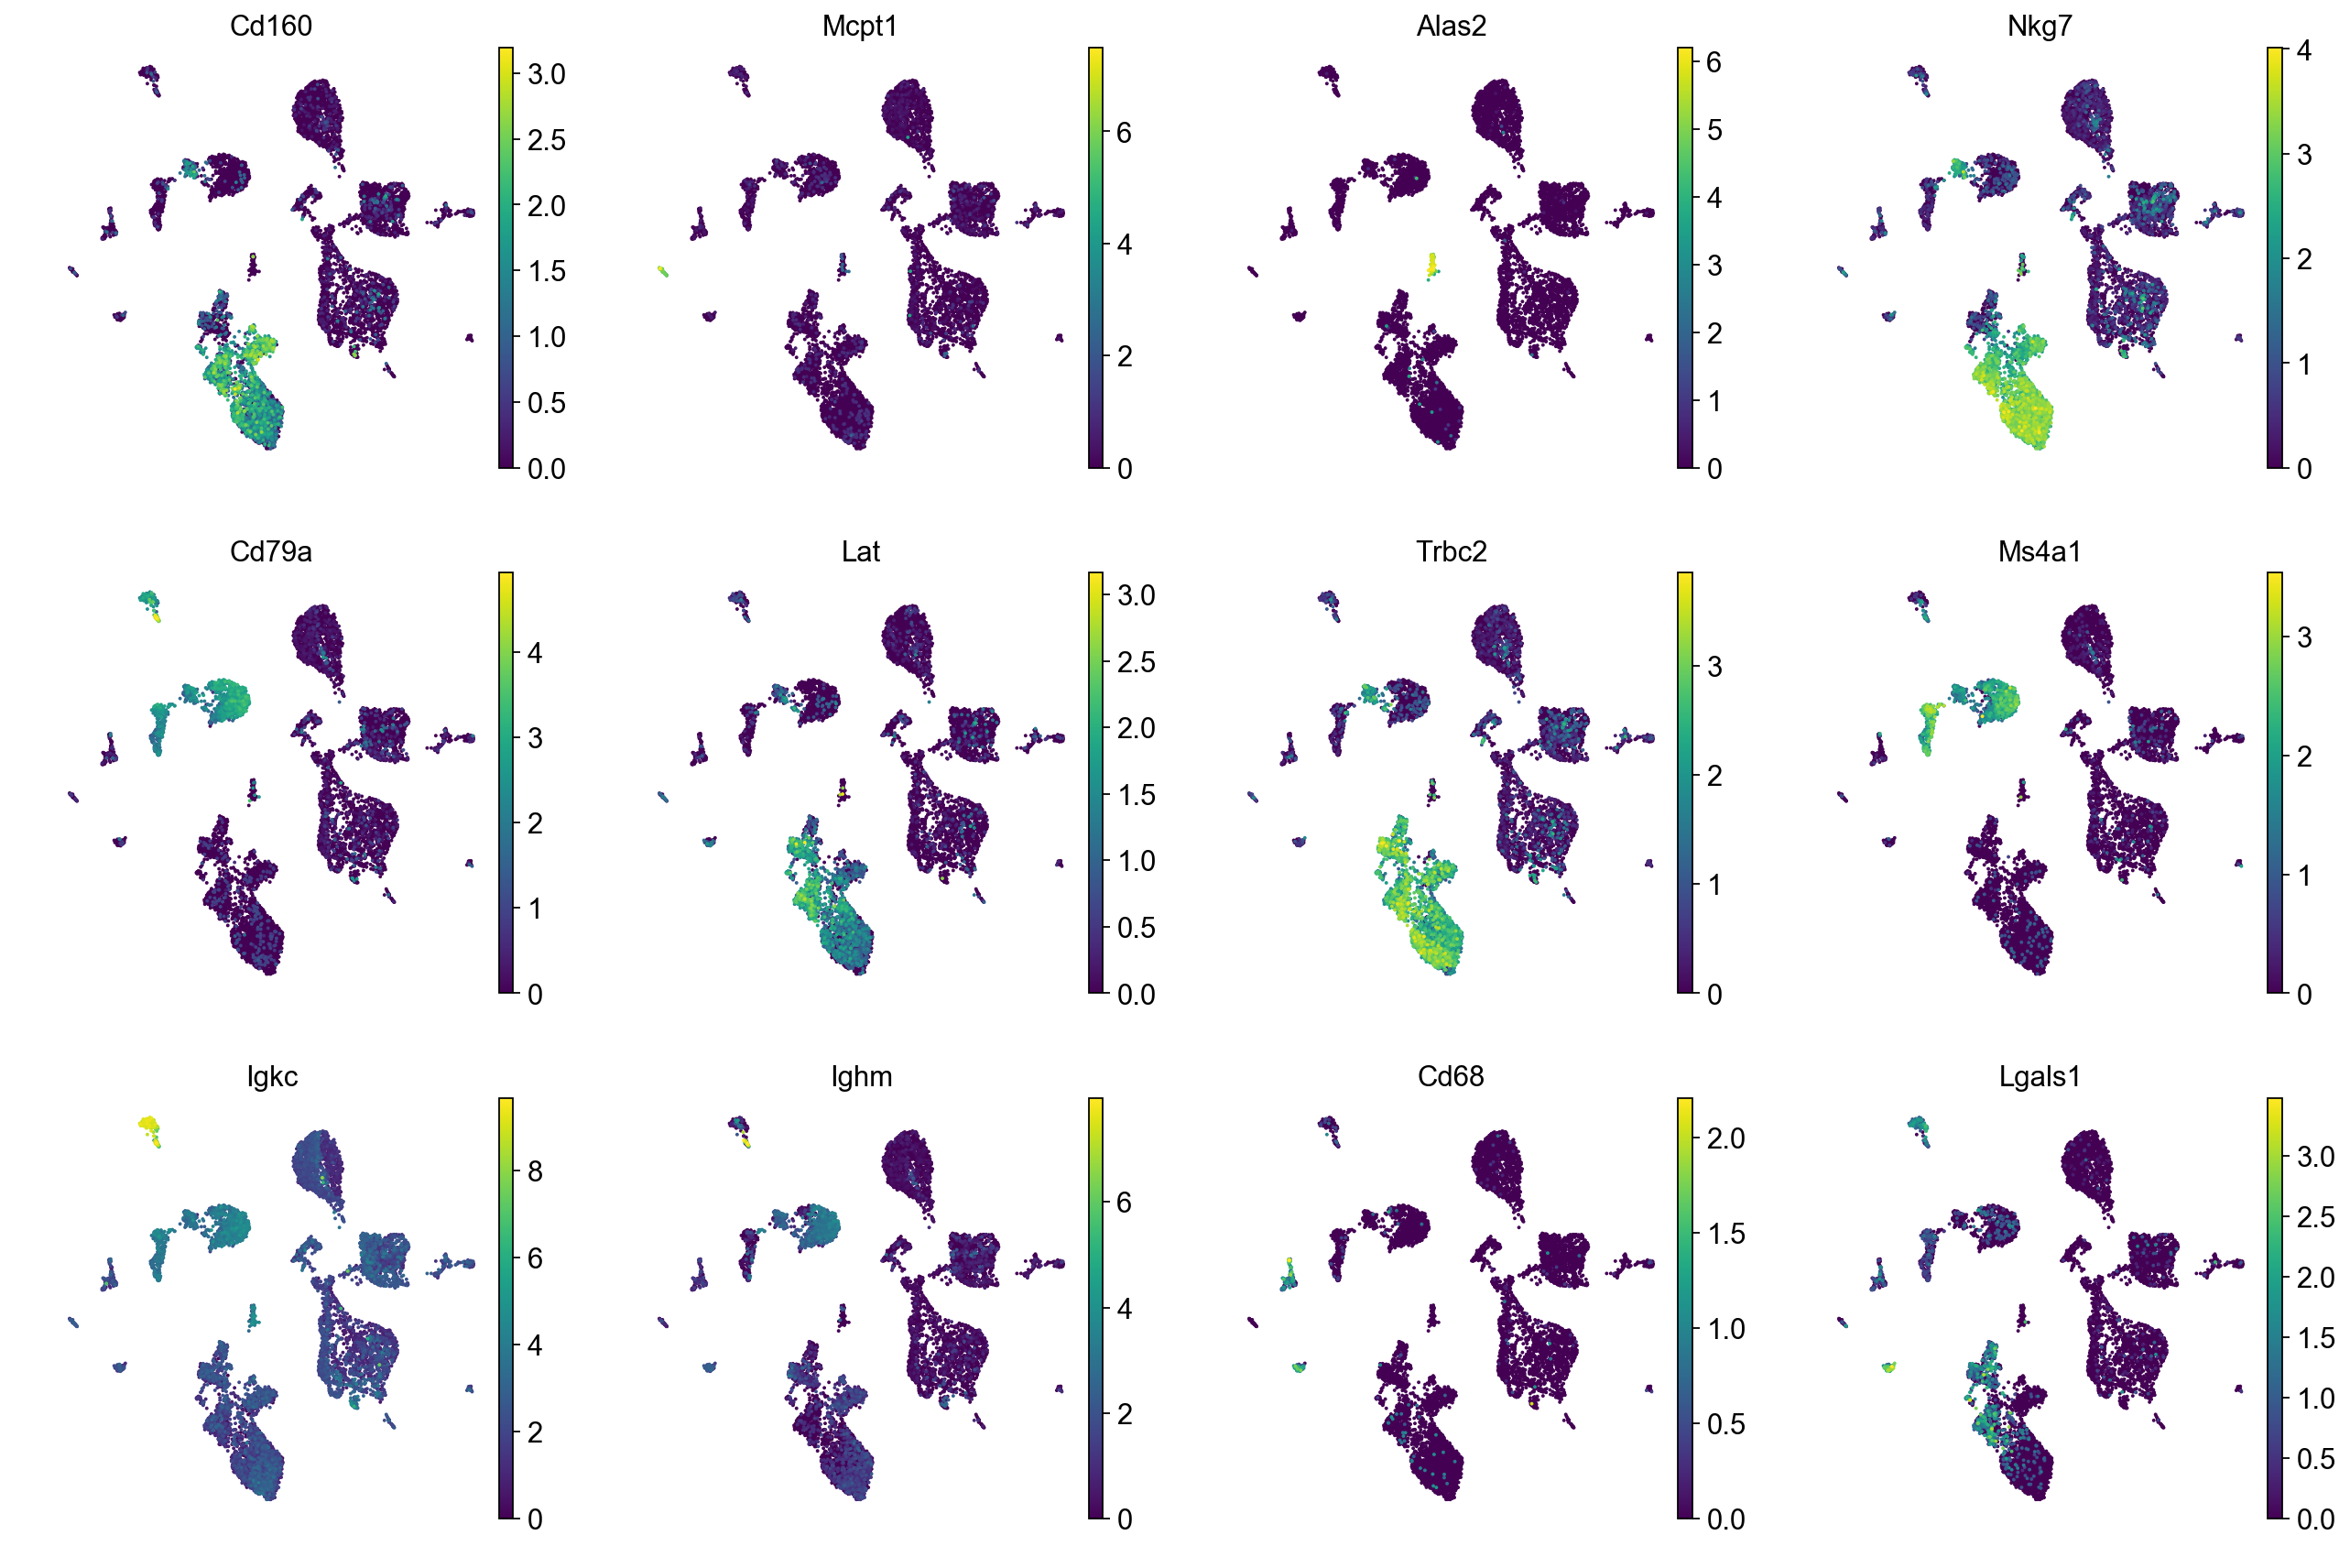

In [22]:
sc.pl.umap(adata, color=['Cd160', 'Mcpt1', 'Alas2', 'Nkg7', 'Cd79a', 'Lat', 'Trbc2', 'Ms4a1', 'Igkc', 'Ighm', 'Cd68', 'Lgals1'])

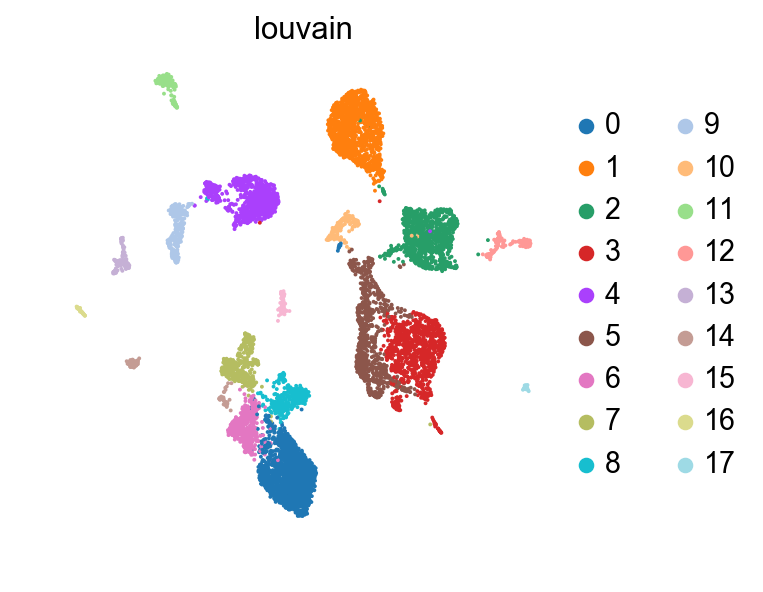

In [23]:
sc.pl.umap(adata, color=['louvain'])

exclude immune cells and fibroblasts

In [24]:
adata = adata[adata.obs.louvain.isin(['1', '2', '3', '5', '10', '12', '17'])].copy()

### filter genes

In [25]:
sc.pp.filter_genes(adata, min_cells=5)

filtered out 4670 genes that are detectedin less than 5 cells


### filter cells with high mt fraction

In [26]:
# exclude dying cells (high mt)
adata = adata[adata.obs['mt_fraction'] < 0.3].copy()
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

Number of cells after MT filter: 4403


In [27]:
adata.uns['diet_colors'] = ['darkgrey', 'red']

### exclude additional immune cell and double clusters

In [28]:
sc.pp.highly_variable_genes(adata, n_top_genes=4000)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:02)
computing UMAP
    finished (0:00:05)


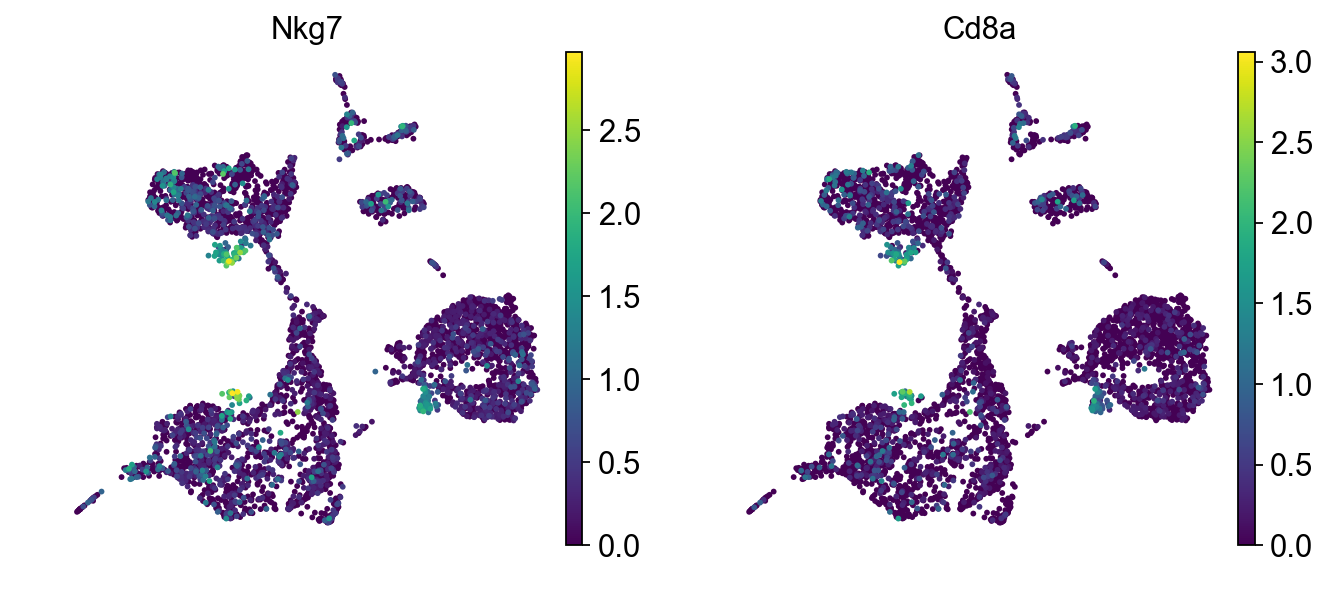

In [29]:
# still few immune cell and doublet clusters
sc.pl.umap(adata, color=['Nkg7', 'Cd8a'])

In [30]:
sc.tl.louvain(adata, resolution=0.6)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


In [31]:
sc.tl.louvain(adata, restrict_to=('louvain',['0']), key_added='louvain_r', resolution=0.35)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


In [32]:
sc.tl.louvain(adata, restrict_to=('louvain_r',['4']), key_added='louvain_r', resolution=0.35)
sc.tl.louvain(adata, restrict_to=('louvain_r',['2']), key_added='louvain_r', resolution=0.35)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


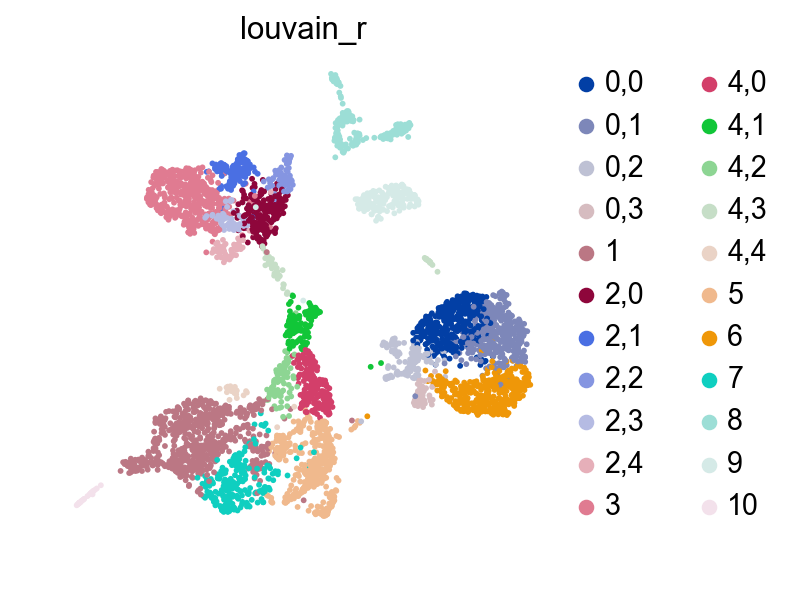

In [33]:
sc.pl.umap(adata, color=['louvain_r'])

In [34]:
adata = adata[np.invert(adata.obs.louvain_r.isin(['0,3', '4,4', '2,4']))].copy()

### Apply more stringent mt fraction filter

In [35]:
adata = adata[adata.obs['mt_fraction'] < 0.25]

## Final manifold and clustering

### manifold

In [36]:
sc.pp.highly_variable_genes(adata, n_top_genes=4000)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Trying to set attribute `.var` of view, copying.


Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing UMAP
    finished (0:00:05)


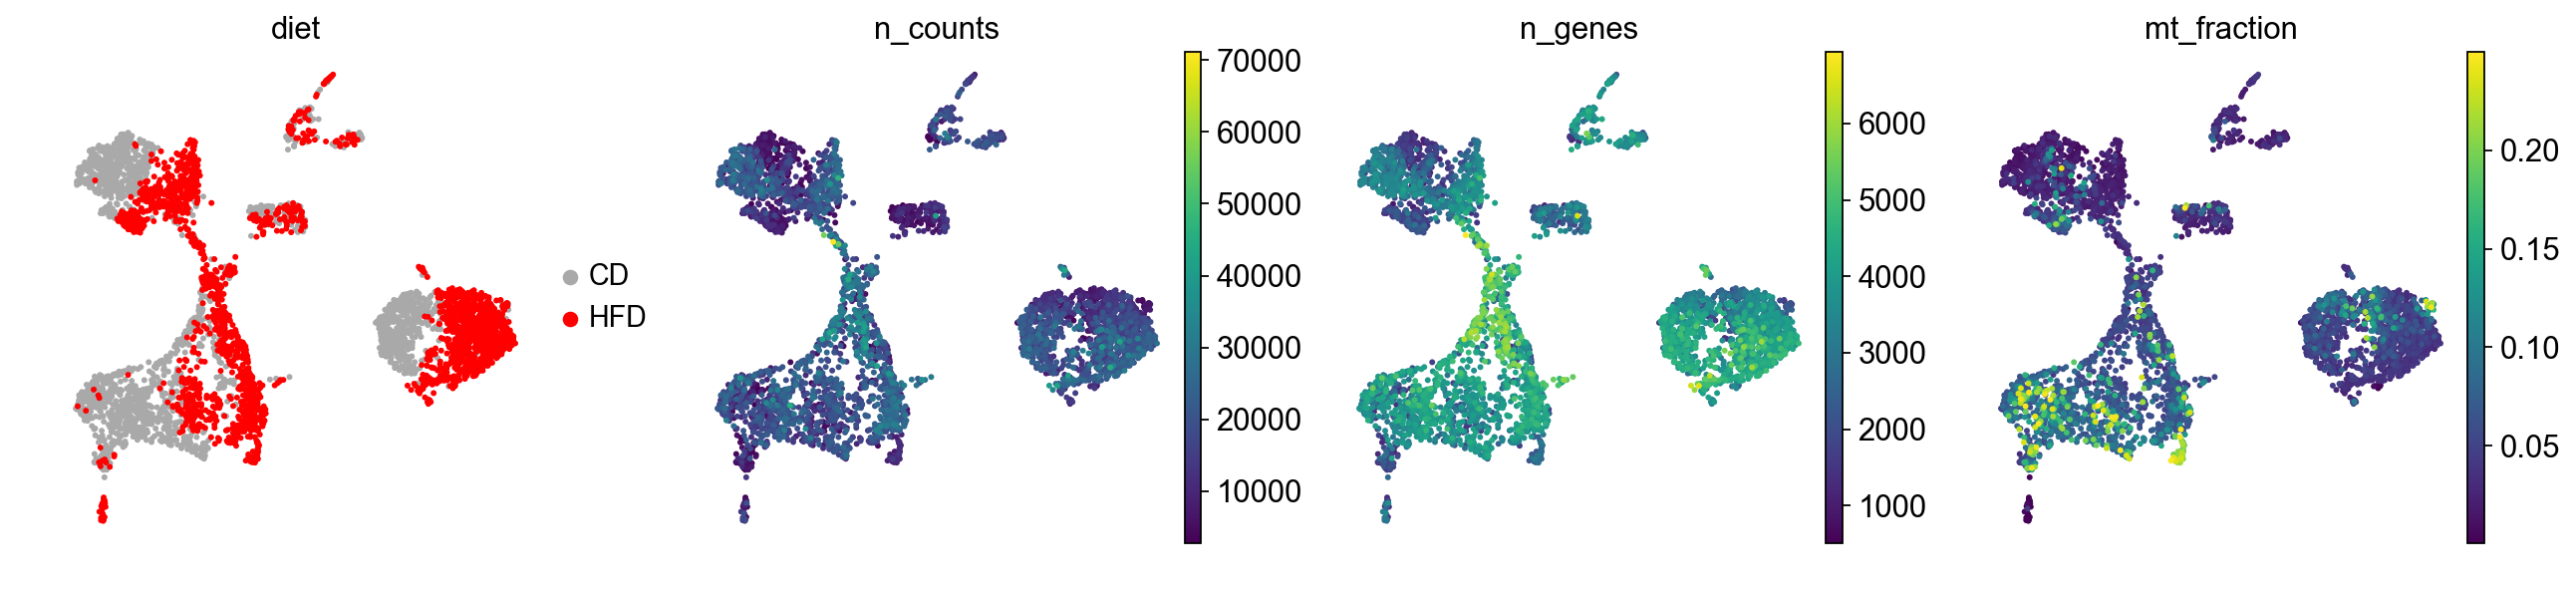

In [37]:
sc.pl.umap(adata, color=['diet','n_counts','n_genes', 'mt_fraction'])

### marker genes

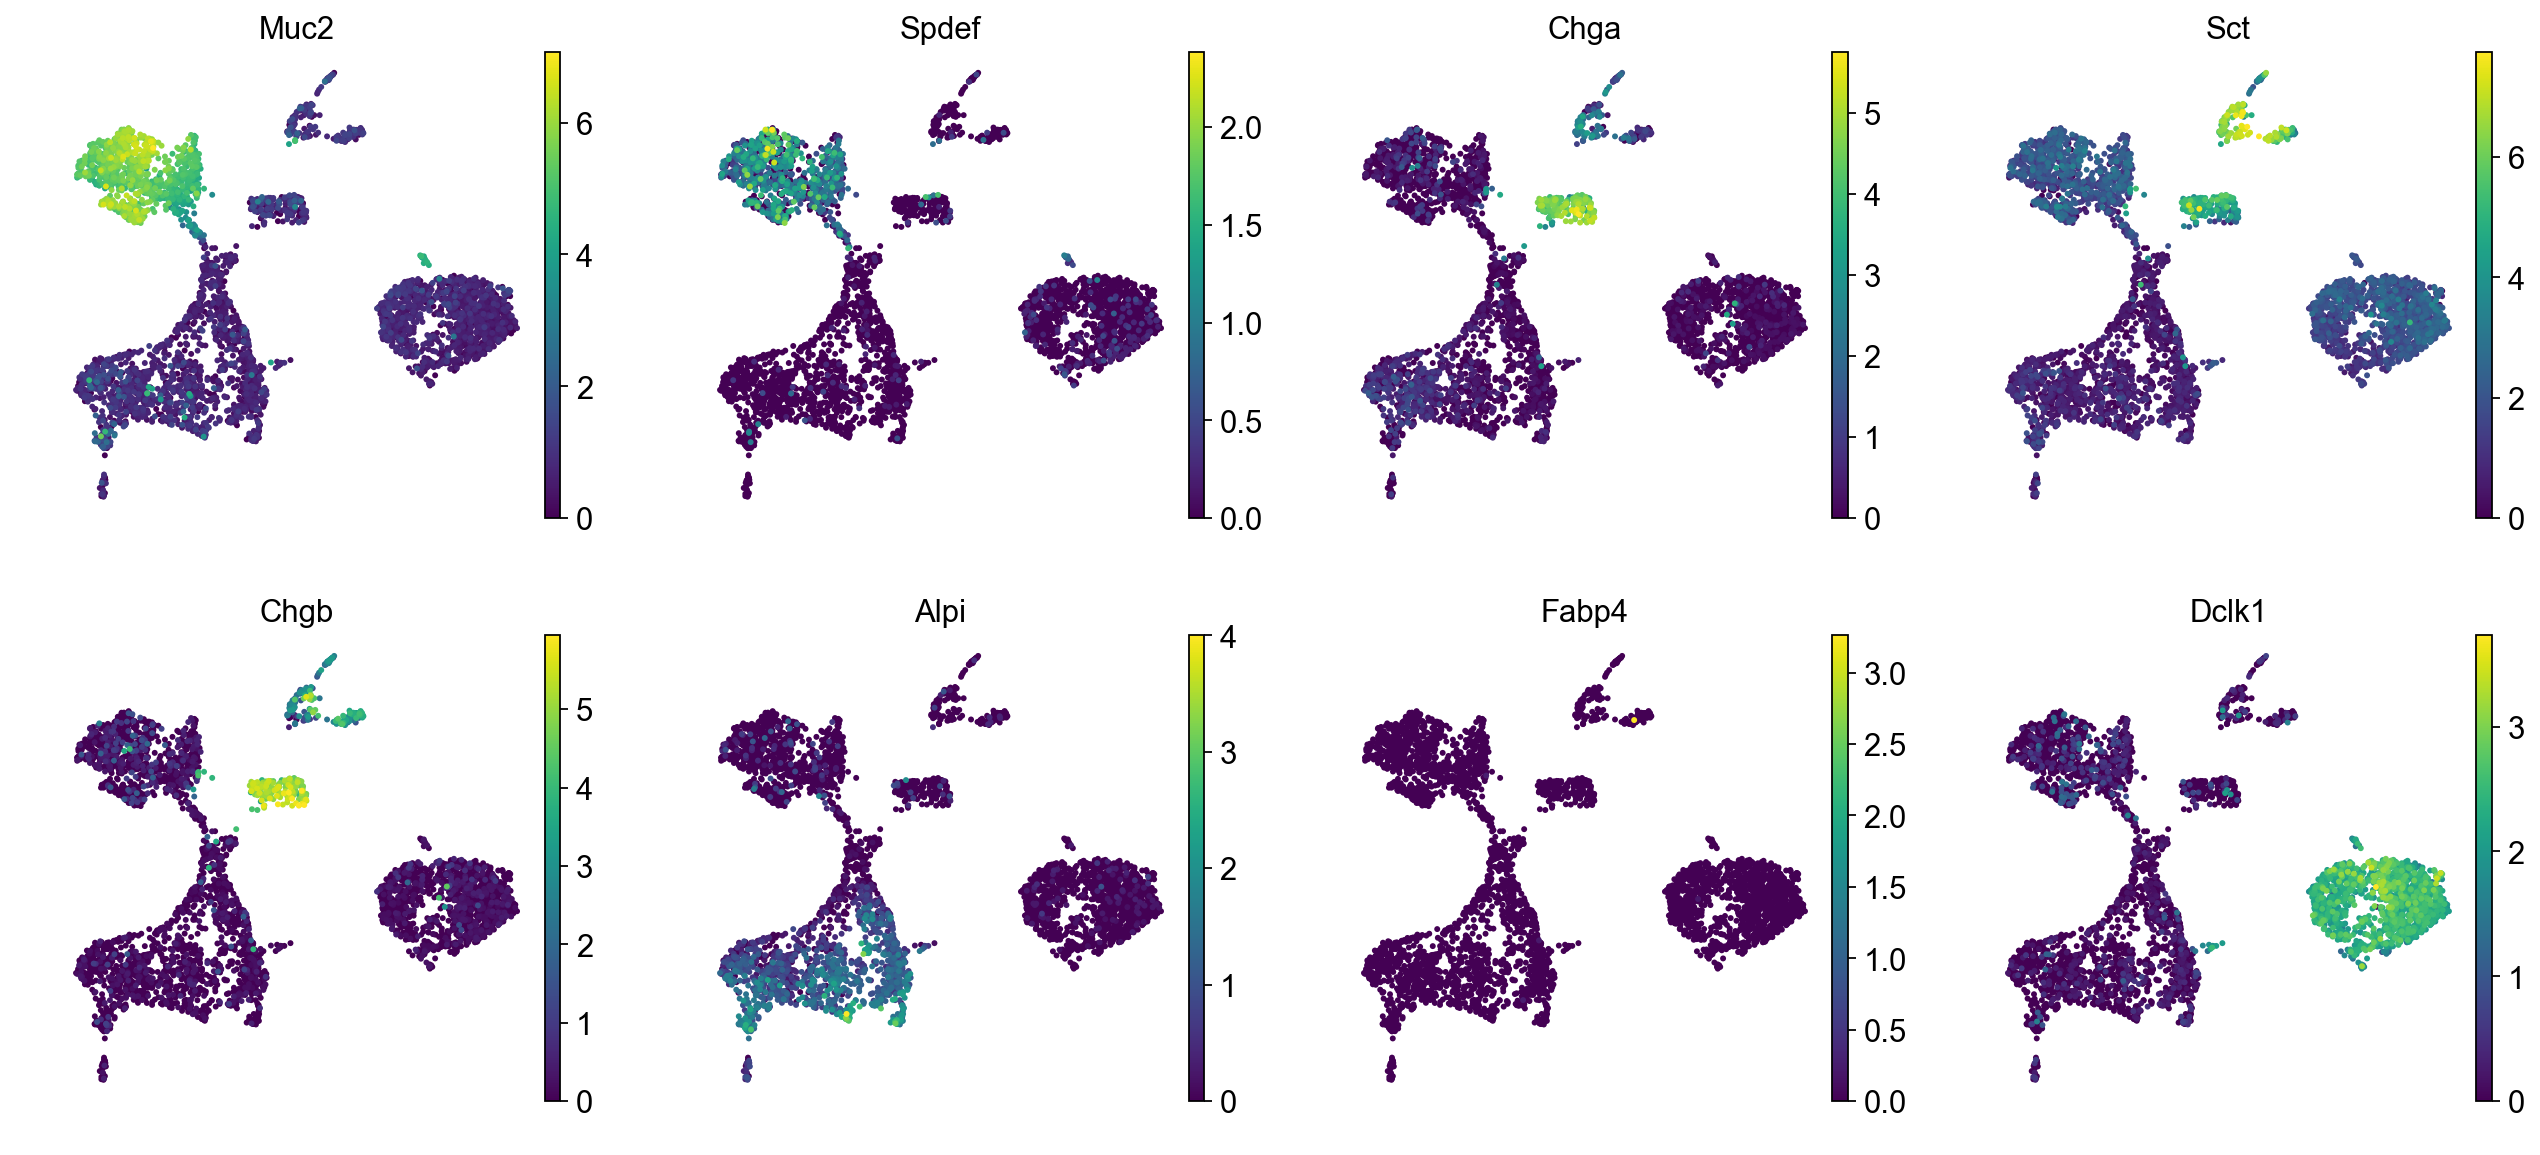

In [38]:
sc.pl.umap(adata, color=['Muc2', 'Spdef', 'Chga', 'Sct', 'Chgb', 'Alpi', 'Fabp4', 'Dclk1'])

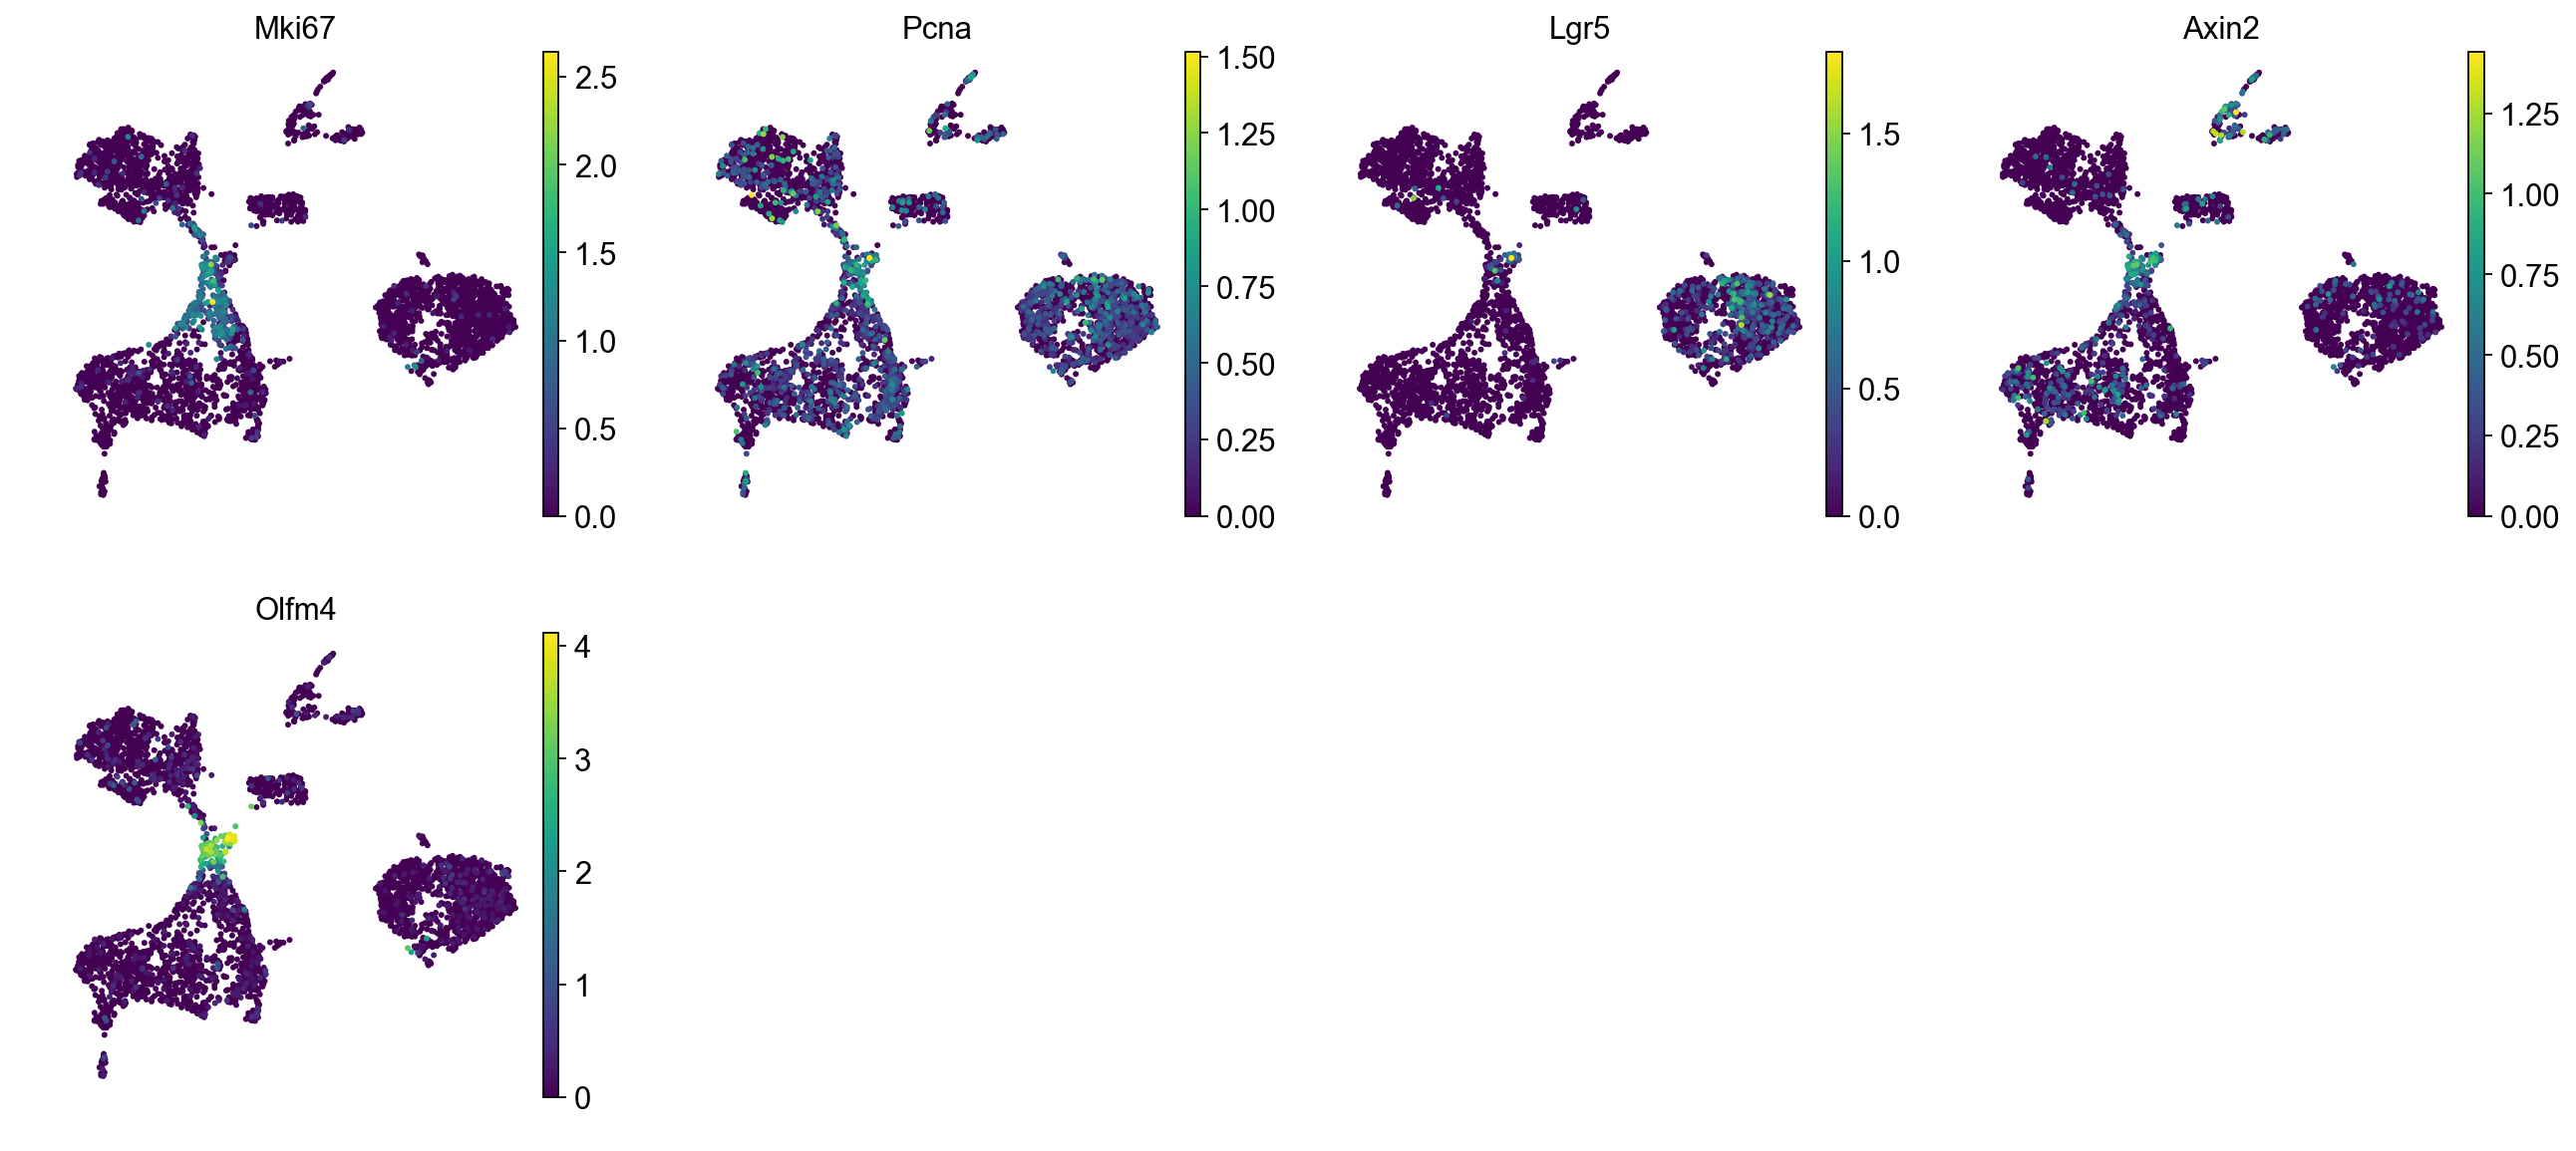

In [39]:
sc.pl.umap(adata, color=['Mki67', 'Pcna', 'Lgr5', 'Axin2', 'Olfm4'])

### clustering

In [40]:
sc.tl.louvain(adata, resolution=0.5)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


In [41]:
sc.tl.louvain(adata, restrict_to=('louvain',['4']), key_added='louvain_r', resolution=0.2)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


In [42]:
sc.tl.louvain(adata, restrict_to=('louvain_r',['2']), key_added='louvain_r', resolution=0.45)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


In [43]:
sc.tl.louvain(adata, restrict_to=('louvain_r',['2,4']), key_added='louvain_r', resolution=0.2)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


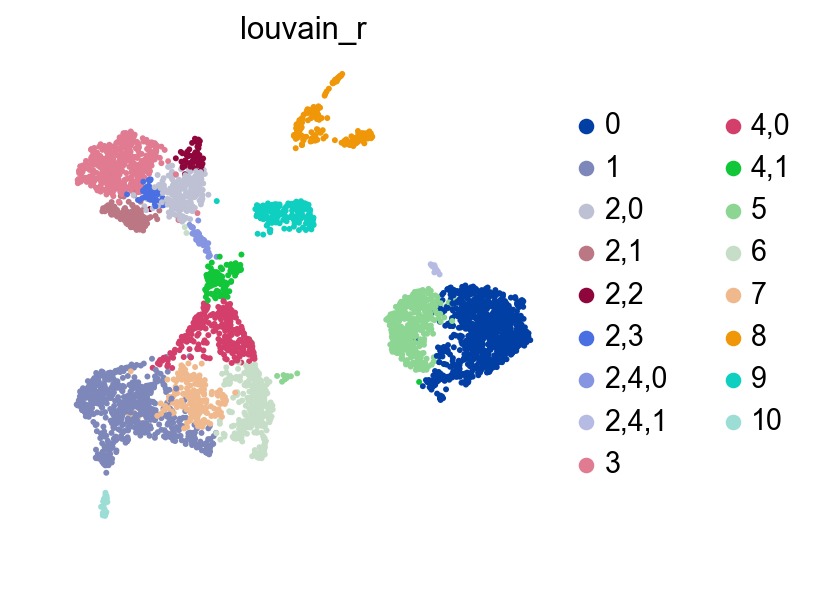

In [44]:
sc.pl.umap(adata, color=['louvain_r'])

### cluster annotation

In [46]:
# annotation
map_names = {}
for c in adata.obs['louvain_r'].cat.categories:
    if c in ['1', '6', '7', '4,3']:
        map_names[c] = 'enterocyte'
    elif c in ['4,0']:
        map_names[c] = 'EP'
    elif c in ['4,1']:
        map_names[c] = 'ISC'
    elif c in ['2,4,0']:
        map_names[c] = 'GP'
    elif c in ['2,0', '2,1', '3', '2,3', '2,2']:
        map_names[c] = 'goblet'
    elif c in ['9', '8']:
        map_names[c] = 'EEC'        
    elif c in ['5', '0']:
        map_names[c] = 'Tuft'
    elif c in ['10', '2,4,1']:
        map_names[c] = '?'
    else:
        map_names[c] = c

adata.obs['louvain_anno']=adata.obs['louvain_r']
adata.obs['louvain_anno']=adata.obs['louvain_anno'].map(map_names).astype('category')


In [49]:
adata.obs.louvain_anno = adata.obs.louvain_anno.cat.reorder_categories(['ISC', 'EP', 'enterocyte', 'GP', 'goblet', 'EEC', 'Tuft', '?'])

In [50]:
adata.uns['louvain_anno_colors']=[
'#1f78b4',
'#b2df8a',
'#33a02c',
'#fb9a99',
'#e31a1c',                          
#'#fdbf6f',
'#ff7f00',
#'#cab2d6',
'#6a3d9a',                                       
#'#dfc27d',
#'#b15928',
#'#f0f0f0'
'#d9d9d9',
]

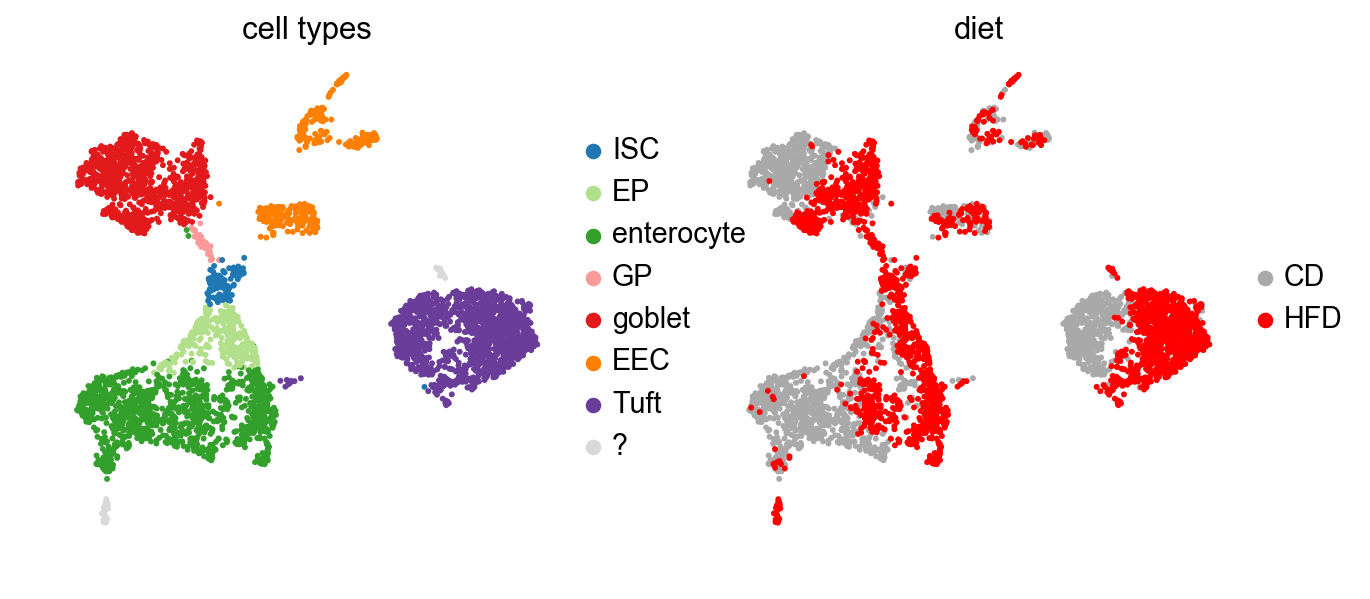

In [52]:
sc.pl.umap(adata, color=['louvain_anno', 'diet'], title=['cell types', 'diet'])

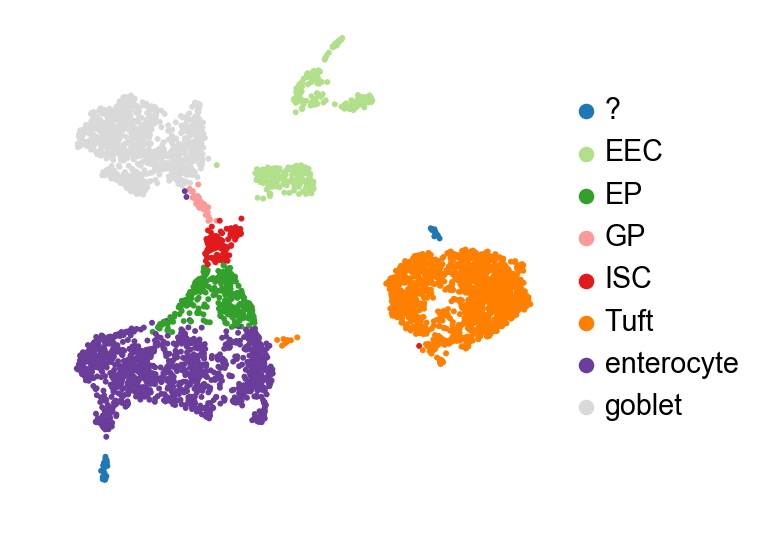

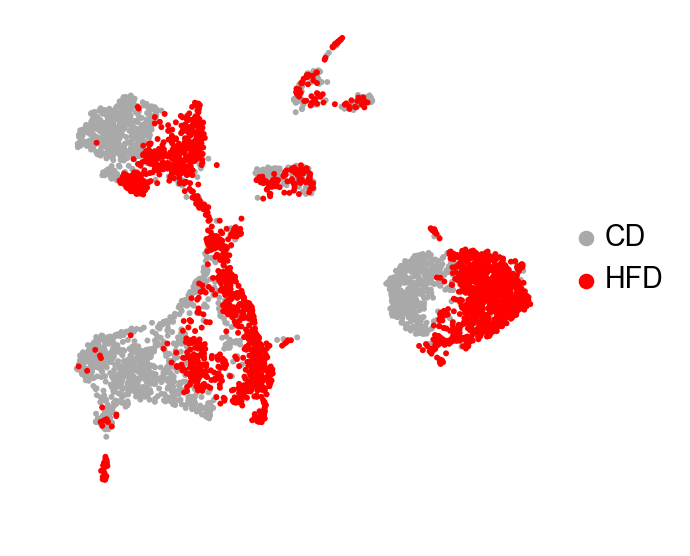

In [101]:
# save figures
sc.pl.umap(adata, color=['louvain_anno'], title=[''], save='_epithelial_cell_types.pdf')
sc.pl.umap(adata, color=['diet'], title=[''], save='_epithelial_diet.pdf')

### Cell densities

In [51]:
sc.tl.embedding_density(adata, groupby='diet', basis='umap', key_added='density_diet')

computing density on 'umap'
--> added
    'density_diet', densities (adata.obs)
    'density_diet_params', parameter (adata.uns)


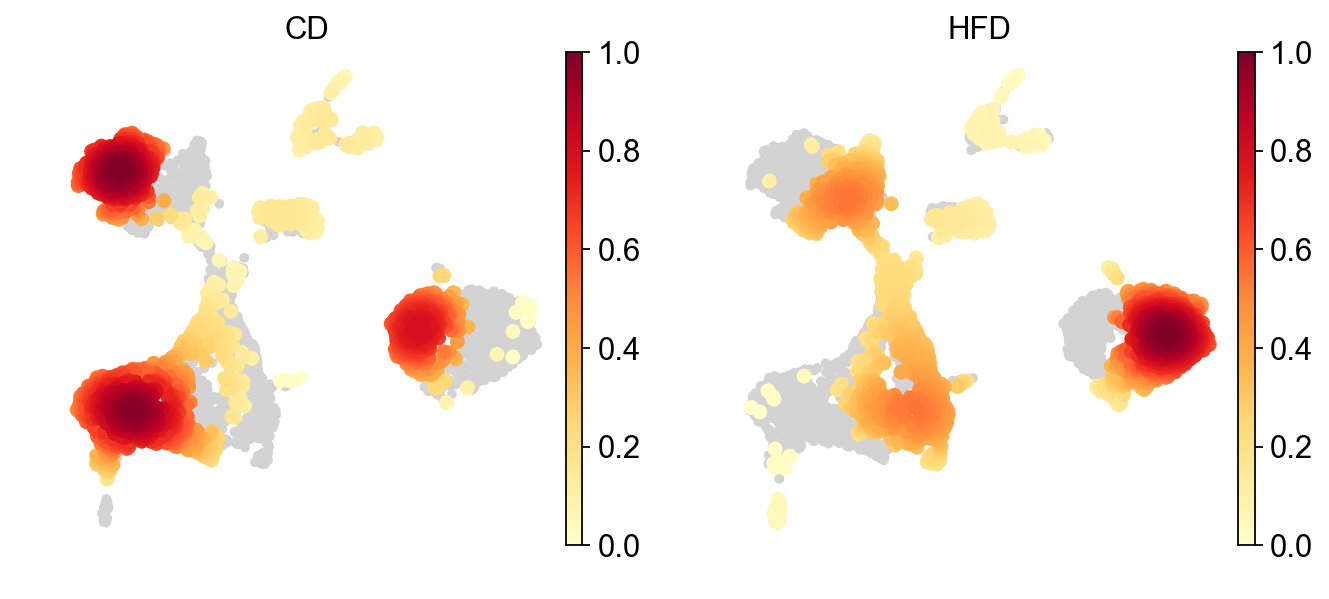

In [52]:
sc.pl.embedding_density(adata, key='density_diet', basis='umap')

### Save adata

In [116]:
adata

AnnData object with n_obs × n_vars = 4205 × 16697 
    obs: 'diet', 'mt_fraction', 'n_counts', 'n_genes', 'louvain', 'louvain_r', 'louvain_anno', 'density_diet'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'density_diet_params', 'diet_colors', 'louvain', 'louvain_anno_colors', 'louvain_r_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [54]:
sc.write('./data/adata_villus_processed.h5ad', adata)